## Test E-matrix estimation on calibrated images
- Images are taken from https://www.microsoft.com/en-us/research/project/a-flexible-new-technique-for-camera-calibration-2/
- Two 480 x 640 RGB images
- Using Harris corners to find Correspondence candidates
- Hand-pick a few true correspondences, to estimate a ground-truth E for comparison

## 1. Retrieve corners from calibrated image

In [1]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt

himg1 = cv2.imread('teatin1.png') # third dimension: colour (BGR)
himg2 = cv2.imread('teatin2.png')
himg1 = cv2.cvtColor(himg1, cv2.COLOR_BGR2RGB)
himg2 = cv2.cvtColor(himg2, cv2.COLOR_BGR2RGB)

In [2]:
himg2.shape

(480, 640, 3)

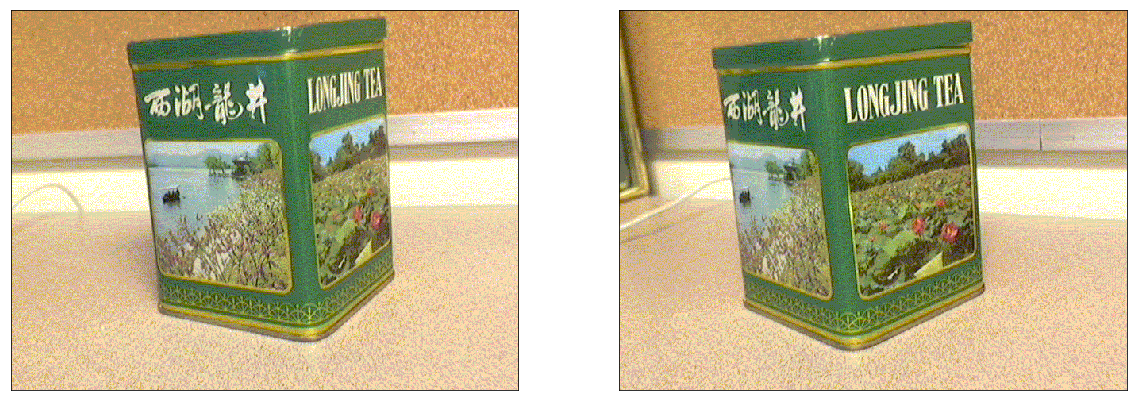

In [3]:
plt.figure(1, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(himg1, cmap = None, interpolation = None) 
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.subplot(1, 2, 2)
plt.imshow(himg2, cmap = None, interpolation = None)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()

In [4]:
def img2harris(img, window=13, n_top=200):
    """
    Returns numpy array (num_corners, 2) of top n_top harris corners.

    Parameters
    ----------
    img : BGR image with values in 0-255
        Image returned by call to cv2.imread().
    window : integer
        Image is split into a mosaic of window x window regions. 
        For each region, only the highest corner value is kept.
    n_top: integer
        The remaining corner values are sorted, and the coordinates 
        of the top n_top corners are returned.
    
    """
    
    # convert to gray
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    
    # find harris corners
    dst = cv2.cornerHarris(gray,2,3,0.04)
    
    highest = np.zeros_like(dst)
    
    # split into mosaic, keep only highest value per region
    for r in range(0, dst.shape[0], 13):
        r_end = min(r + window, dst.shape[0])
        for c in range(0, dst.shape[1], 13):
            # define end of window (limited by right edge of image)
            c_end = min(c + window, dst.shape[1])
            
            # write highest value to zeroed matrix
            m = np.max(dst[r:r_end, c:c_end])
            i = np.where(dst[r:r_end, c:c_end] == m)
            
            highest[r:r_end, c:c_end][i] = m
    
    # get top 200 from highest
    ind = np.argpartition(highest, -n_top, None)[-n_top:]
    ind = np.unravel_index(ind, highest.shape)
    
    return ind

In [5]:
# Store Harris corners in ind1, ind2
ind1 = img2harris(himg1)
ind2 = img2harris(himg2)

himg1_disp = himg1.copy()
himg2_disp = himg2.copy()

# Mark corners with red dots
# himg1_disp[ind1] = [0,0,255]
# himg2_disp[ind2] = [0,0,255]

for pt1 in (np.array(ind1).T):
    himg1_disp = cv2.circle(himg1_disp,tuple([pt1[1],pt1[0]]),2,(255,0,0),-1)

for pt2 in (np.array(ind2).T):
    himg2_disp = cv2.circle(himg2_disp,tuple([pt2[1],pt2[0]]),2,(255,0,0),-1)

In [6]:
# Collect indices of corners
pts1 = np.array(ind1).T.astype(float)
pts2 = np.array(ind2).T.astype(float)

## 2. Run Particle Filter

In [7]:
import helpers
import numpy as np
from helpers import projectPoints, transformCamera
from math import sin, cos, pi

In [8]:
from importlib import reload
reload(helpers)

<module 'helpers' from 'D:\\Courses\\NUS\\DCVPC\\code\\helpers.py'>

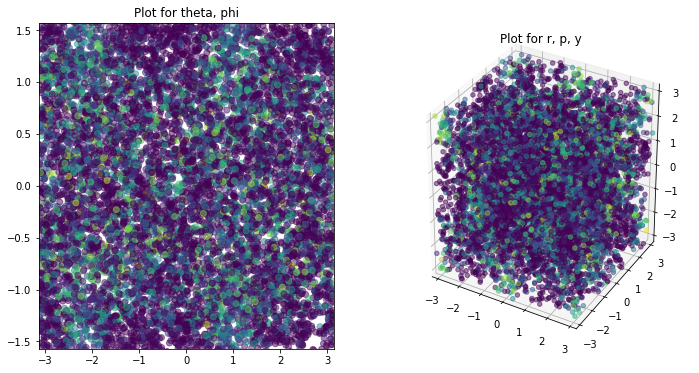

First 200 scores: [0, 7, 3, 13, 0, 0, 35, 0, 28, 0, 18, 30, 6, 59, 0, 57, 0, 54, 70, 0, 2, 23, 0, 55, 106, 22, 0, 62, 0, 41, 22, 26, 56, 0, 0, 76, 0, 0, 0, 3, 0, 85, 0, 0, 2, 0, 56, 0, 100, 16, 24, 44, 95, 0, 0, 11, 0, 0, 0, 13, 43, 0, 21, 34, 0, 0, 0, 63, 42, 4, 18, 7, 15, 0, 70, 1, 95, 0, 3, 0, 63, 84, 21, 106, 0, 0, 16, 34, 0, 15, 84, 22, 83, 24, 0, 56, 0, 3, 31, 38, 47, 13, 0, 4, 63, 9, 0, 0, 47, 34, 14, 109, 0, 0, 33, 17, 6, 43, 10, 1, 20, 35, 1, 0, 2, 0, 72, 33, 4, 0, 0, 5, 1, 0, 94, 0, 0, 0, 17, 80, 76, 19, 0, 0, 1, 40, 73, 20, 0, 19, 42, 4, 0, 4, 15, 23, 1, 51, 0, 0, 76, 2, 0, 0, 23, 0, 3, 83, 0, 0, 81, 0, 12, 0, 3, 8, 39, 7, 3, 45, 0, 0, 0, 86, 3, 77, 2, 84, 0, 33, 84, 0, 4, 1, 7, 65, 0, 0, 0, 17]
Non-match ratio: 0.000000 (0/228760)
Sigma: ['0.080000', '0.080000', '0.080000', '0.080000', '0.080000']
Epsilon: 3.000000
Iteration: 1
Elapsed time: 13.215925s


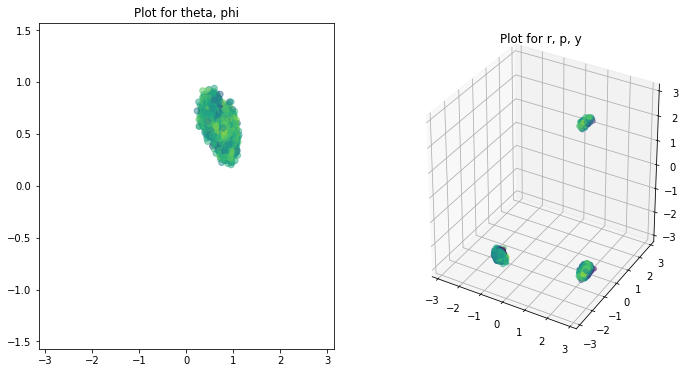

First 200 scores: [93, 110, 108, 108, 106, 82, 111, 116, 104, 107, 111, 101, 101, 111, 110, 105, 106, 94, 108, 102, 116, 106, 114, 116, 111, 103, 105, 110, 108, 116, 102, 111, 105, 109, 105, 115, 103, 115, 105, 95, 108, 113, 107, 108, 116, 111, 115, 109, 109, 115, 104, 96, 110, 101, 121, 114, 112, 113, 109, 115, 110, 117, 98, 118, 108, 109, 108, 98, 109, 103, 104, 103, 104, 109, 96, 114, 110, 114, 110, 116, 107, 96, 106, 107, 111, 110, 103, 106, 104, 104, 92, 115, 101, 115, 118, 109, 114, 112, 114, 103, 111, 110, 108, 101, 114, 113, 108, 101, 101, 114, 108, 112, 100, 116, 113, 96, 105, 101, 115, 109, 109, 120, 118, 111, 108, 111, 116, 98, 104, 105, 121, 109, 100, 118, 102, 114, 98, 114, 106, 106, 105, 105, 113, 107, 109, 118, 106, 115, 112, 104, 107, 104, 114, 93, 112, 107, 113, 96, 106, 99, 114, 115, 109, 104, 109, 106, 114, 114, 115, 112, 112, 109, 102, 113, 113, 108, 114, 102, 110, 121, 105, 112, 107, 112, 105, 101, 108, 110, 95, 124, 105, 110, 116, 107, 108, 114, 110, 99, 117, 118]

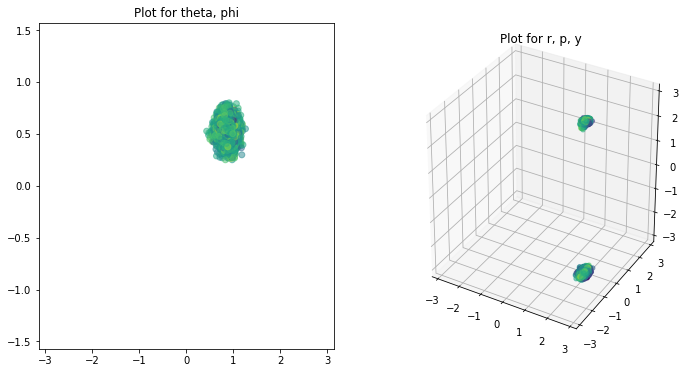

First 200 scores: [117, 107, 117, 113, 94, 109, 109, 96, 99, 110, 101, 112, 110, 113, 99, 110, 102, 108, 94, 103, 103, 103, 109, 105, 109, 105, 106, 99, 114, 117, 106, 116, 119, 116, 101, 115, 113, 110, 103, 111, 108, 112, 101, 106, 112, 107, 113, 116, 118, 119, 107, 106, 109, 109, 95, 108, 118, 120, 103, 116, 92, 104, 113, 107, 113, 121, 110, 113, 114, 108, 110, 108, 113, 117, 109, 117, 109, 107, 114, 99, 111, 104, 110, 107, 113, 111, 115, 117, 116, 109, 102, 121, 107, 114, 117, 108, 98, 121, 114, 108, 106, 108, 105, 116, 108, 107, 107, 111, 113, 105, 110, 108, 110, 113, 106, 110, 107, 103, 113, 103, 105, 113, 112, 110, 98, 110, 102, 113, 100, 106, 113, 105, 115, 114, 112, 103, 119, 113, 110, 115, 105, 110, 113, 115, 109, 118, 112, 113, 113, 102, 104, 117, 107, 106, 108, 118, 119, 112, 108, 111, 119, 109, 112, 107, 115, 111, 109, 122, 105, 112, 120, 117, 110, 110, 111, 111, 103, 114, 118, 123, 119, 112, 106, 108, 119, 104, 116, 109, 111, 114, 113, 110, 110, 105, 114, 113, 109, 113, 11

In [9]:
from helpers import ParticleFilter, generateSamples
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import time

n_corr = 0
start_time = time.time()
# ---------------------------------------------------------
# Adjustable parameters
# ---------------------------------------------------------

iterations = 10
m = 10000

# Set range to be a uniform cube of length 1 around the solution
# ranges = np.array([[*diff_sph-0.5, 1/m], [*diff_sph+0.5, 1/m]]).T  

ranges = np.array([[-pi, pi],
                   [-pi/2, pi/2],
                   [-pi, pi], 
                   [-pi, pi], 
                   [-pi, pi], 
                   [1/m, 1/m]])

e = 3
sigma = np.array([*[0.08]*5]) 

# Multiply sigma by a factor after a number of iterations
sigma_factor   = 0.8
sigma_interval = 5 

# Multiply epsilon by a factor after a number of iterations
e_factor   = 1 #0.5
e_interval = 5

# ---------------------------------------------------------

S_new = generateSamples(m, ranges)

for i in range(iterations):
    S_new, score_list, nmc, mc = ParticleFilter(S_new, sigma, pts1, pts2, n_corr, epsilon = e, epipole_t = 0.3, norm_mode = "softmax")
    
    # Print for every 5 iterations, and for the last iteration
    if i%5 == 0 or i+1 == iterations: 
        fig = plt.figure(figsize = (18,6))

        ax1 = fig.add_subplot(131)
        ax1.scatter(*S_new[:2,:], c= score_list, alpha=0.5)
        ax1.set_xlim(*ranges[0])
        ax1.set_ylim(*ranges[1])
        ax1.set_title("Plot for theta, phi")
        
        ax2 = fig.add_subplot(132, projection='3d')
        ax2.scatter(*S_new[2:5,:], c= score_list, alpha=0.5)
        ax2.set_xlim3d(*ranges[2])
        ax2.set_ylim3d(*ranges[3])
        ax2.set_zlim3d(*ranges[4])
        ax2.set_title("Plot for r, p, y")
        
        if S_new.shape[0] == 8:
            ax3 = fig.add_subplot(133)
            ax3.scatter(*S_new[5:7,:], c= score_list, alpha=0.5)
            ax3.set_xlim(*ranges[5])
            ax3.set_ylim(*ranges[6])
            ax3.set_title("Plot for f1, f2")

        plt.show()

        print("First 200 scores: " + str(score_list[:200])) # print first 200 scores only
        print("Non-match ratio: %f (%d/%d)" % (nmc/mc, nmc, mc))
        print("Sigma: " + str(["{0:f}".format(s) for s in sigma]))
        print("Epsilon: %f" % (e))
        print("Iteration: %d" % (i+1))
        print("Elapsed time: %fs" % (time.time() - start_time))
        
    # Decrease sigma over iterations
    if sigma_factor != 1 and (i+1) % sigma_interval == 0:
        sigma *= sigma_factor
    
    # Decrease epsilon over iterations
    if e_factor != 1 and (i+1) % e_interval == 0:
        e *= e_factor

## 3. Recover solution from Particle Filter

In [10]:
# Print average
ave = np.average(S_new[:-1, :], axis = 1)
print("Average:      " + str(ave))

Average:      [ 0.8679808   0.52191473  2.01694425 -0.38698885 -2.25869425]


[[ 0.86425934  0.52204274  2.02230492 -0.39442896 -2.99883626]
 [ 0.89488866  0.52098913  1.97818421 -0.3331935   3.09286751]]


C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Users\arborea\Anaconda3\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:728: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


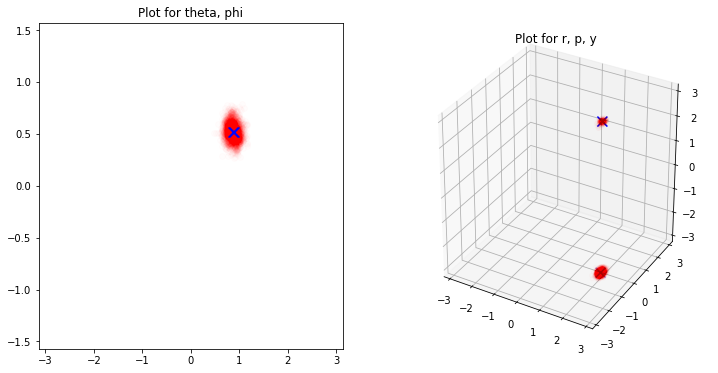

In [14]:
# Retrieve clusters
from sklearn.cluster import KMeans

num_clusters = 2

kmeans_model = KMeans(n_clusters = num_clusters).fit(S_new[:-1, :].T)
results = kmeans_model.cluster_centers_
print(results)

res = results.T

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax1.scatter(*S_new[:2,:m//4], c='red', alpha=0.01)
ax1.scatter(*res[:2,:], c='blue', marker='x', s=100)
ax1.set_xlim(*ranges[0])
ax1.set_ylim(*ranges[1])
ax1.set_title("Plot for theta, phi")

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(*S_new[2:,:m//4], c='red', alpha=0.01)
ax2.scatter(*res[2:,:], zdir='z', c='blue', marker='x', s=100)
ax2.set_xlim3d(*ranges[2])
ax2.set_ylim3d(*ranges[3])
ax2.set_zlim3d(*ranges[4])
ax2.set_title("Plot for r, p, y")
plt.show()

In [15]:
# Construct E from solution t and r, check that (pts1)' E (pts2) = 0

from helpers import rpy2R, xyz2T, sphericalToCartesian

pts1_uvf = np.concatenate((pts1, np.ones((pts1.shape[0], 1))), axis = 1)
pts2_uvf = np.concatenate((pts2, np.ones((pts2.shape[0], 1))), axis = 1)

E_results = []
E_products = []
for res_idx in range(results.shape[0]):
    t  = sphericalToCartesian(1, *results[res_idx, :2])
    r  = results[res_idx, 2:]
    
    T = xyz2T(t[0], t[1], t[2])
    R = rpy2R(r[0], r[1], r[2])
    E = np.dot(T,R)
    E_results.append(E)
    E_products.append(pts1_uvf @ E @ pts2_uvf.T)

In [16]:
E_results

[array([[ 0.82596735,  0.45079305, -0.0988163 ],
        [ 0.3283017 , -0.8638672 ,  0.04578978],
        [-0.45212898,  0.20963888,  0.01686917]]),
 array([[ 0.77648639,  0.46428122, -0.29077382],
        [ 0.35840434, -0.84879569,  0.01764172],
        [-0.43923299,  0.21332233,  0.09649538]])]

Comparing all n' x n matches


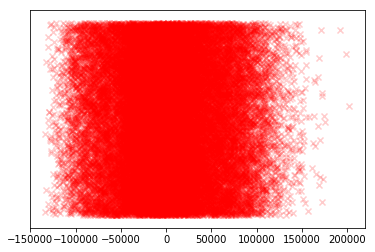

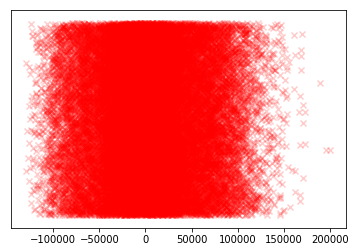

In [17]:
print("Comparing all n' x n matches")
for sol in E_products:
    vals = sol.flatten()
    plt.scatter(vals, np.random.rand(vals.shape[0]), marker='x', color='r', alpha = 0.2)
    plt.yticks([])
    plt.show()

## Plot epipolar lines with E

In [18]:
def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c,ch = img1.shape
    
    img1 = img1.copy()
    img2 = img2.copy()
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        y0,x0 = map(int, [0, -r[2]/r[1] ])
        y1,x1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple([pt1[1],pt1[0]]),4,color,-1)
        img2 = cv2.circle(img2,tuple([pt2[1],pt2[0]]),4,color,-1)
    return img1,img2

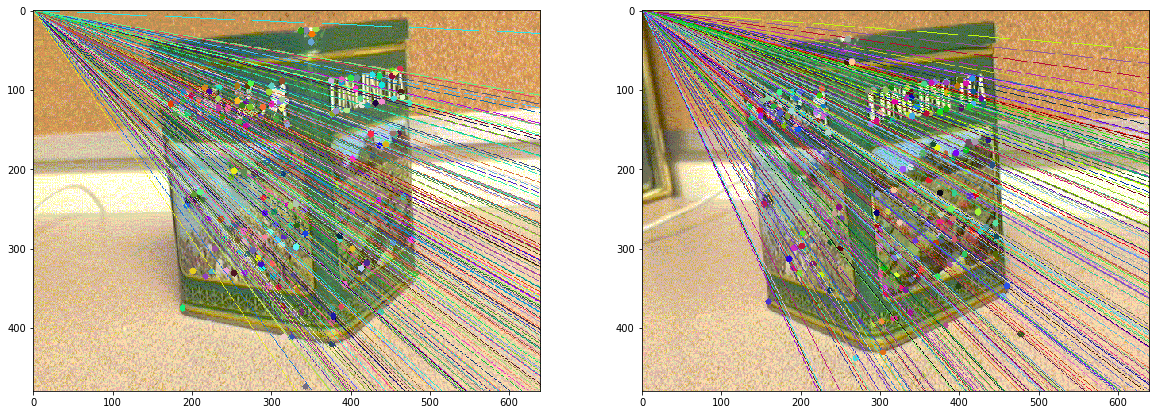

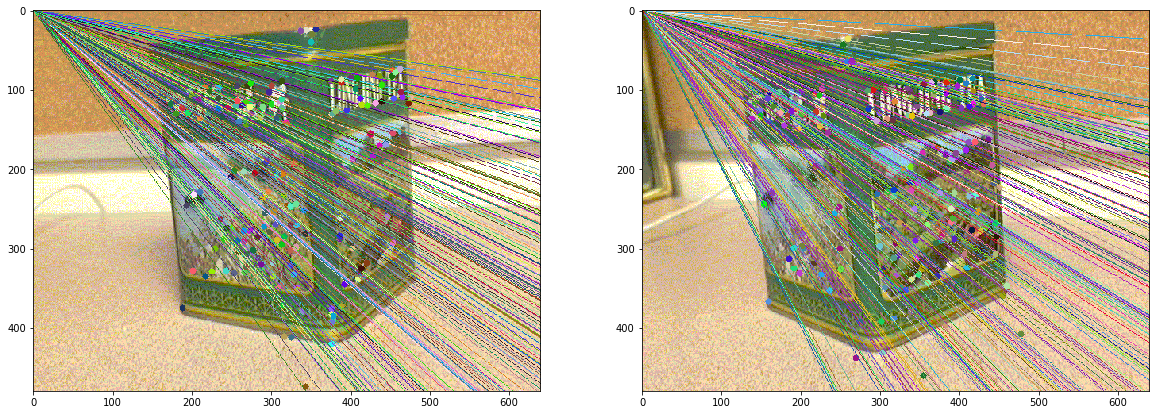

In [20]:
for E in E_results:
    # Find epilines corresponding to points (whichImage contains the points, the other image contains lines)

    lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 1, E)
    lines1 = lines1.reshape(-1,3)
    img5,img6 = drawlines(himg1,himg2,lines1,pts1.astype(int),pts2.astype(int))

    # Find epilines corresponding to points in left image (first image) and
    # drawing its lines on right image

    lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 2, E)
    lines2 = lines2.reshape(-1,3)
    img3,img4 = drawlines(himg2,himg1,lines2,pts2.astype(int),pts1.astype(int))

    plt.figure(2, figsize=(20,10))
    plt.subplot(121),plt.imshow(img5)
    plt.subplot(122),plt.imshow(img3)
    plt.show()

In [52]:
del img3, img4, img5, img6

## Estimate ground truth for comparison

In [21]:
# Hand-pick correspondences for ground truth
c1 = np.array([[375., 188.],
               [118., 173.],
               [330., 482.],
               [188., 402.],
               [246., 193.],
               [144., 320.],
               [131., 376.],
               [30., 351.],
               [109., 465.]
              ])

c2 = np.array([[367., 159.],
               [122., 135.],
               [347., 459.],
               [200., 328.],
               [244., 153.],
               [154., 234.],
               [143., 288.],
               [43., 253.],
               [118., 430.]
              ])

F, inliers = cv2.findFundamentalMat(c1,c2,cv2.FM_8POINT)
print(inliers)

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [22]:
lines1 = cv2.computeCorrespondEpilines(c2.reshape(-1,1,2), 1, F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(himg1,himg2,lines1,c1.astype(int),c2.astype(int))

# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image

lines2 = cv2.computeCorrespondEpilines(c1.reshape(-1,1,2), 2, F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(himg2,himg1,lines2,c2.astype(int),c1.astype(int))


Estimated ground truth from hand-picked coordinates


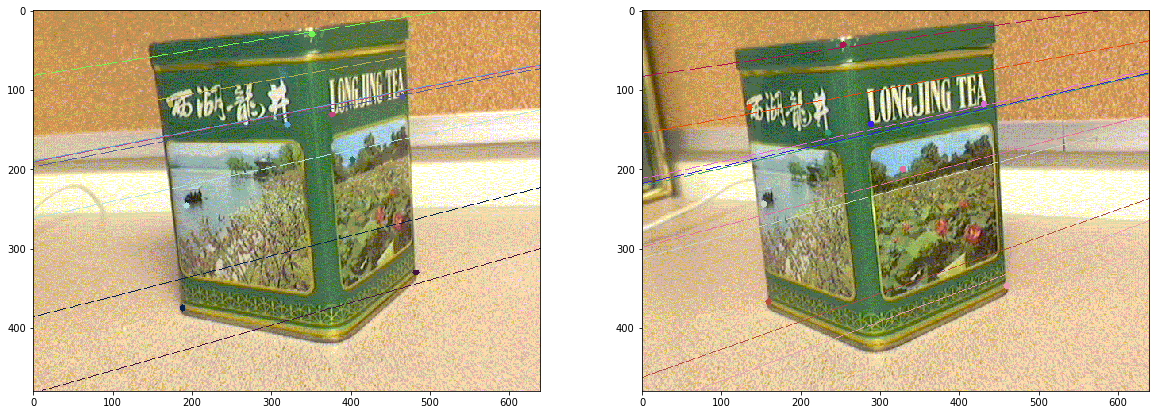

In [23]:
print("Estimated ground truth from hand-picked coordinates")
plt.figure(2, figsize=(20,10))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

## Misc.

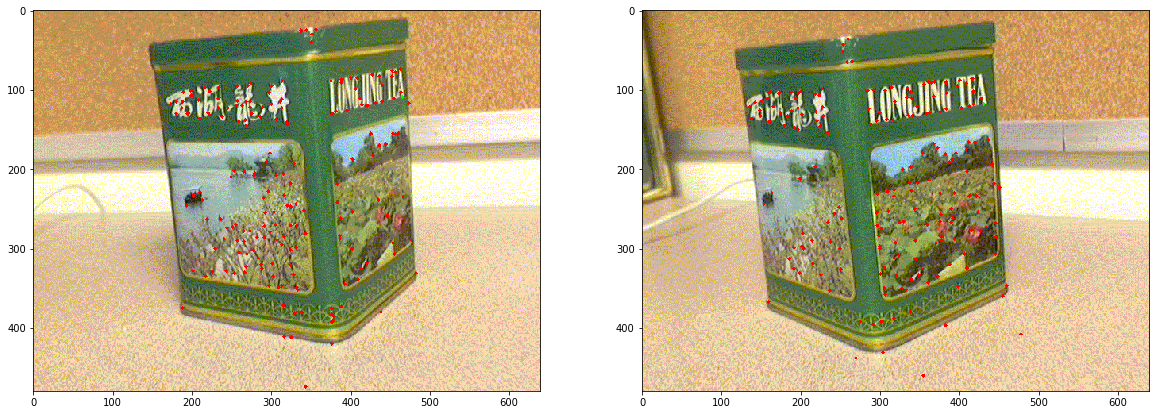

In [24]:
# For choosing correspondences manually 

co1 = [109., 465.]
co2 = [118., 430.]
co1.reverse()
co2.reverse()
co1 = np.array(co1)
co2 = np.array(co2)
himg1_disp = cv2.circle(himg1_disp,tuple(co1.astype(int)),2,(0,255,0),-1)
himg2_disp = cv2.circle(himg2_disp,tuple(co2.astype(int)),2,(0,255,0),-1)

# Display results
plt.figure(1, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.imshow(himg1_disp)
# plt.xticks([]), plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(himg2_disp)
# plt.xticks([]), plt.yticks([])

plt.show()